In [3]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import inspect, create_engine, func, and_

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [9]:
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [10]:
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurements', 'stations']

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
# Save references to each table
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [16]:
measurement_data = session.query(Measurement).first()
measurement_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x252822373c8>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [17]:
station_data = session.query(Station).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25282237eb8>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [18]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [19]:
session.query(Station.station).order_by(Station.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

<IPython.core.display.Javascript object>


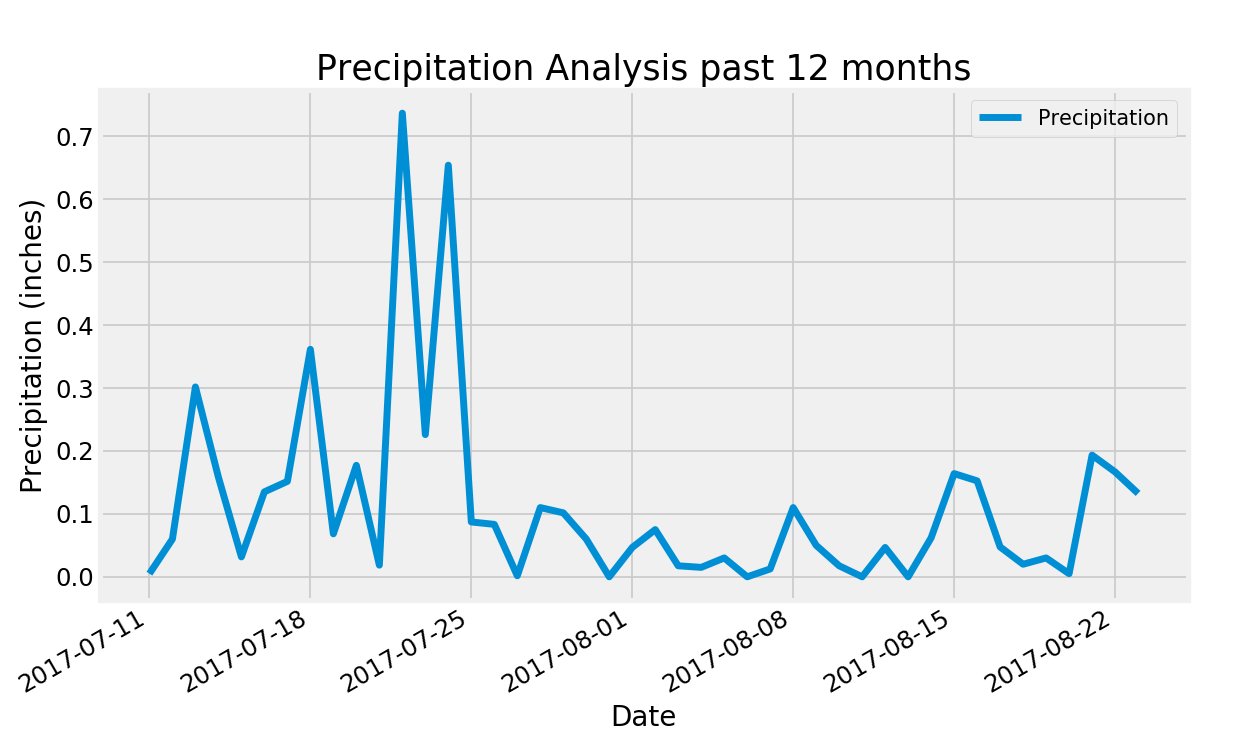

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import date, datetime as dt
from dateutil.relativedelta import relativedelta

# Calculate the date 1 year ago from today
today = date.today()

# one_year_ago_date = today - relativedelta(months=12)
one_year_ago_date_from_today = today - relativedelta(months=12)

# Perform a query to retrieve the date and precipitation scores
measurement_data = session.query(Measurement.date,func.avg(Measurement.prcp)).\
                           filter(Measurement.date >= one_year_ago_date_from_today).\
                           group_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(measurement_data, columns=["Date","Precipitation"]).set_index("Date")

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in precipitation_df.index]
y_axis = precipitation_df["Precipitation"]

# Plot
plt.figure(figsize=(10,6))
plt.plot(x_axis, y_axis)

# Rotate the xticks for the dates
ax = plt.gca()
x_locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(x_locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(x_locator))
plt.gcf().autofmt_xdate() 

# Adding the aesthetics for the plot
plt.title("Precipitation Analysis past 12 months", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.legend(fontsize=12)
plt.savefig("Images/precipitation_analysis_12months.png")
plt.show() 

In [151]:
# precipitation_df

<IPython.core.display.Javascript object>


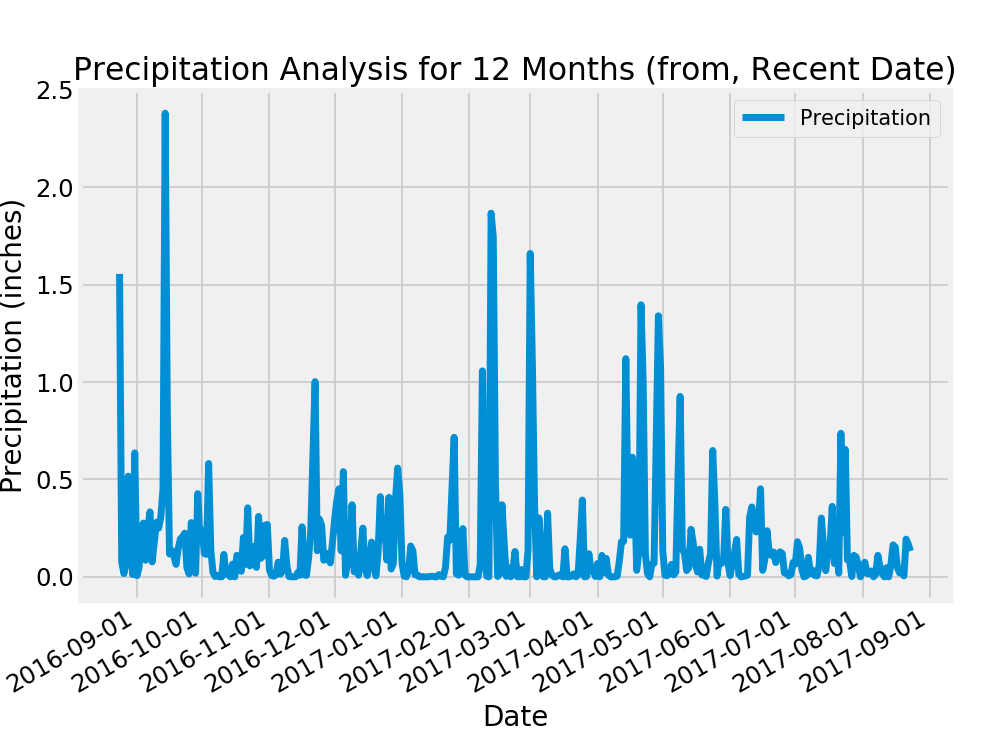

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import date, datetime as dt
from dateutil.relativedelta import relativedelta

# Calculate the date 1 year ago from recent date in the dataframe
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
one_year_ago_date_from_recent_date_indata = dt.strptime(recent_date, "%Y-%m-%d") - relativedelta(months=12)

measurement_data1 = session.query(Measurement.date,func.avg(Measurement.prcp)).\
                           filter(Measurement.date >= one_year_ago_date_from_recent_date_indata).\
                           group_by(Measurement.date).all()
        
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df1 = pd.DataFrame(measurement_data1, columns=["Date","Precipitation"]).set_index("Date")

# Sort the dataframe by date
precipitation_df1.sort_index(inplace=True)

# Process dataset
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in precipitation_df1.index]

# Plot
plt.figure(figsize=(8,6))
plt.plot(index, precipitation_df1["Precipitation"])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Rotation


plt.title("Precipitation Analysis for 12 Months (from, Recent Date)", size=18)
plt.xlabel("Date", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.legend(fontsize=12)
plt.savefig("Images/precipitation_analysis_from_recent_date.png")
plt.show()


In [158]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,44.000000
mean,0.111900
std,0.153017
min,0.000000
25%,0.018304
50%,0.061000
75%,0.151875
max,0.736667


In [22]:
# How many stations are available in this dataset?
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [23]:
# What are the most active stations?
# List the stations and the observation counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,\
              func.min(Measurement.tobs).label("Min Temperature"),\
              func.max(Measurement.tobs).label("Max Temperature"),\
              func.avg(Measurement.tobs).label("Avg Temperature")\
             ).\
        filter_by(station = most_active_stations[0][0]).one()
        

('USC00519281', 54, 85, 71.66378066378067)

The station with the highest number of observations: USC00519281
             tobs
Station          
USC00519281    72
USC00519281    74
USC00519281    74
USC00519281    76
USC00519281    80
USC00519281    80
USC00519281    76
USC00519281    76
USC00519281    76
USC00519281    77
USC00519281    77
USC00519281    77
USC00519281    82
USC00519281    75
USC00519281    77
USC00519281    75
USC00519281    76
USC00519281    81
USC00519281    82
USC00519281    81
USC00519281    76
USC00519281    77
USC00519281    82
USC00519281    83
USC00519281    77
USC00519281    77
USC00519281    77
USC00519281    76
USC00519281    76
USC00519281    79


<IPython.core.display.Javascript object>


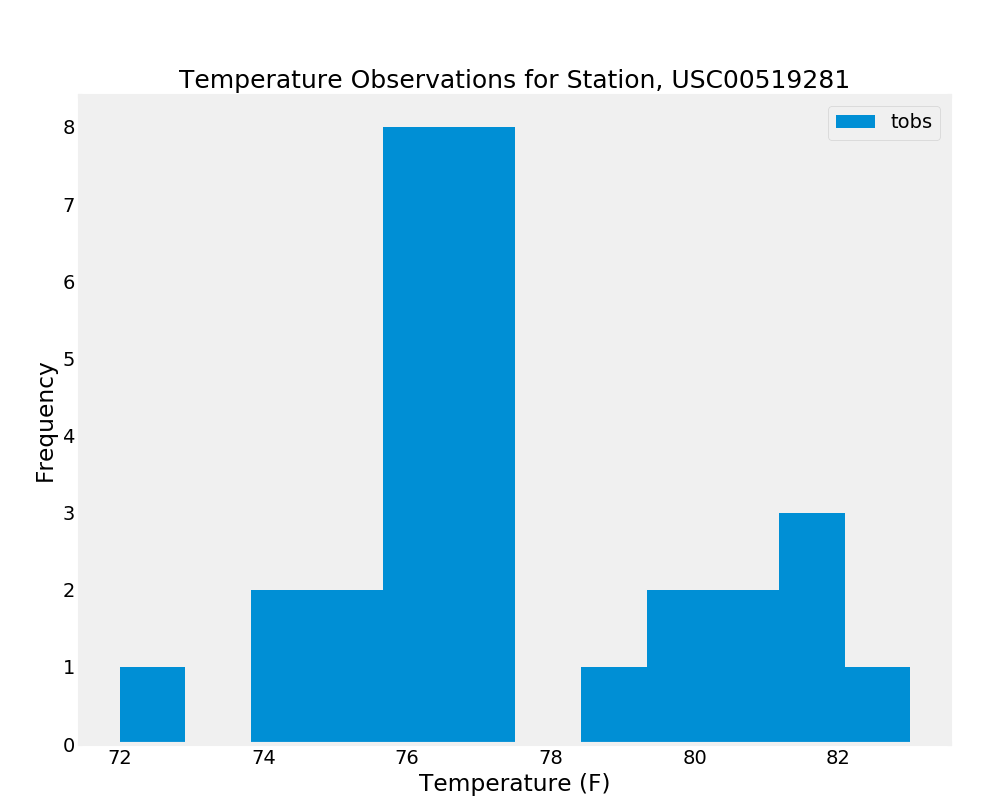

In [30]:
# Choose the station with the highest number of observations.
highest_number_of_obs_station = most_active_stations[0][0]

print(f"The station with the highest number of observations: {highest_number_of_obs_station}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from today
today = date.today()
one_year_ago_date_from_today = today - relativedelta(months=12)

highest_station_tobs_12months = session.query(Measurement.station.label("Station"),\
                                              Measurement.tobs.label("tobs")).\
                                        filter(and_(Measurement.station == highest_number_of_obs_station),\
                                                    Measurement.date >= one_year_ago_date_from_today).\
                                        all()

tobs_12months_df = pd.DataFrame(highest_station_tobs_12months,\
                             columns=["Station", "tobs"])
tobs_12months_df.set_index("Station", inplace=True)
print(tobs_12months_df)

# Plotting a histogram from the dataframe
tobs_12months_df.plot(kind="hist", bins=12, figsize=(10,8))
plt.grid()
plt.title(f"Temperature Observations for Station, {highest_number_of_obs_station}", size=18)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/temperature_analysis.png")
plt.show()

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


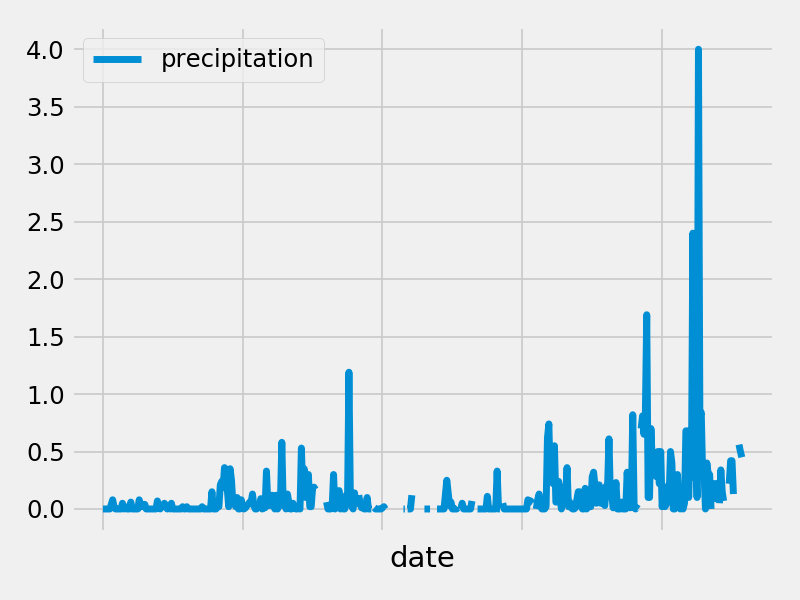

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data


,precipitation
count,412.000000
mean,0.117549
std,0.294210
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.000000


In [12]:
# How many stations are available in this dataset?


[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


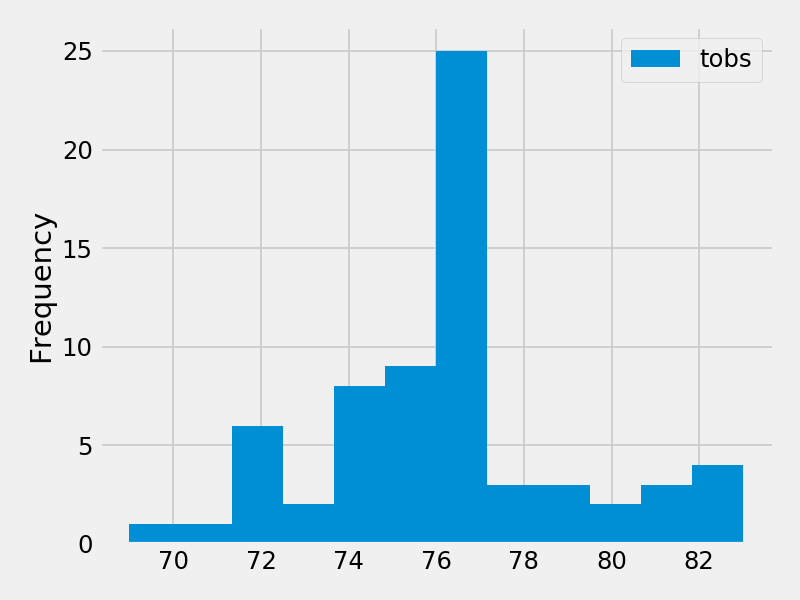

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


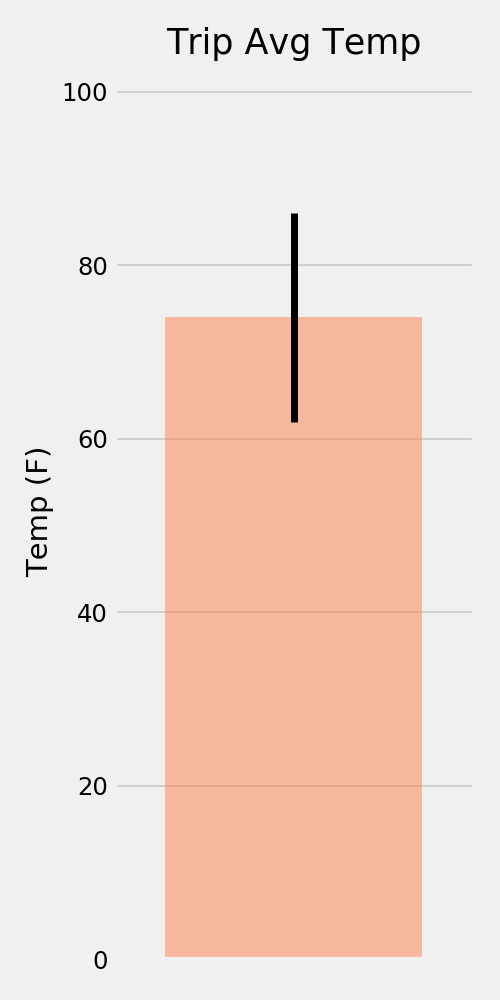

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


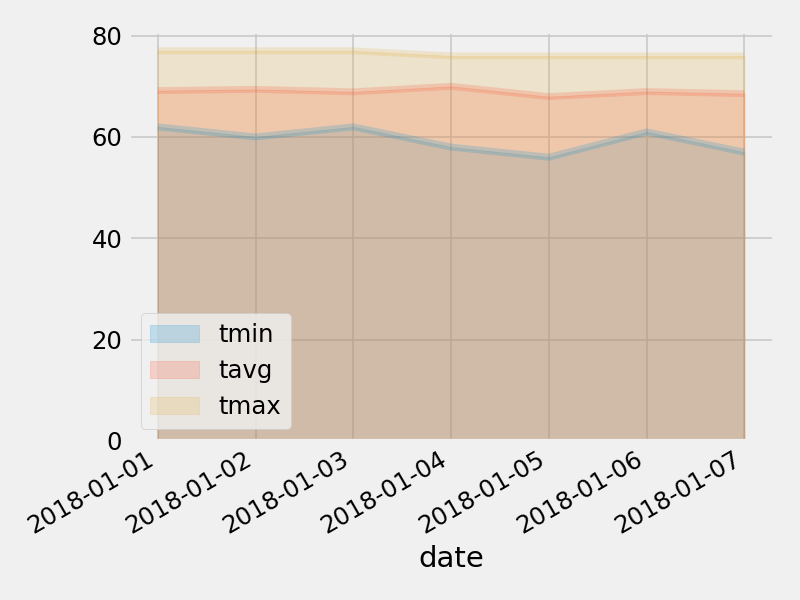

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
